## **Deep Learning in TS**

This the code for running the deep learning in my home value index dataset. 

## Import my file to colab

In [40]:
from google.colab import files
uploaded = files.upload()

Saving hvi_ca.csv to hvi_ca (1).csv


## Split the dataset into train-test and define graph and rmse function

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN
from keras import regularizers

df = pd.read_csv('hvi_ca.csv')
hvi = pd.DataFrame()
hvi['date'] = pd.to_datetime(df['date'])
hvi['value'] = pd.to_numeric(df['index'])
print(hvi)

def Matrix_X_Y(ts: np.array, lag=1, n_ahead=1, target_index=0) -> tuple:
    # Extracting the number of features that are passed from the array
    n_features = ts.shape[1]

    # Creating placeholder lists
    X, Y = [], []

    if len(ts) - lag <= 0:
        X.append(ts)
    else:
        for i in range(len(ts) - lag - n_ahead):
            Y.append(ts[(i + lag):(i + lag + n_ahead), target_index])
            X.append(ts[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y


print(hvi.head())
print(hvi.shape)

ts = hvi[['value']].values
# print(ts)
print(ts.shape)


nrows = ts.shape[0]
test_percent = 0.1
# Spliting into train and test sets
train = ts[0:int(nrows * (1 - test_percent))]
test = ts[int(nrows * (1 - test_percent)):]

# Scaling the data
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std
test = (test - train_mean) / train_std

# Creating the final scaled frame
ts_s = np.concatenate([train, test])

lag = 12
ahead = 3

# Creating the X and Y for training
X, Y = Matrix_X_Y(ts_s, lag=lag, n_ahead=ahead)

Xtrain = X[0:int(X.shape[0] * (1 - test_percent))]
Ytrain = Y[0:int(X.shape[0] * (1 - test_percent))]

Xval = X[int(X.shape[0] * (1 - test_percent)):]
Yval = Y[int(X.shape[0] * (1 - test_percent)):]

# define plot
def plot_model(history, model_title, filename):
    print('History', history.history)
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.title(f'Training loss ({model_title})')
    plt.legend()
    plt.savefig(f'{filename}')

# define the rmse function
def print_error(trainY, testY, train_predict, test_predict):
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(
        trainY[:, 0], train_predict[:, 0]))
    test_rmse = math.sqrt(mean_squared_error(testY[:, 0], test_predict[:, 0]))
    # Print RMSE
    print('Train RMSE: %.3f RMSE' % (train_rmse))
    print('Test RMSE: %.3f RMSE' % (test_rmse))
    return train_rmse, test_rmse


          date   value
0   2000-01-31  235321
1   2000-02-29  235542
2   2000-03-31  236660
3   2000-04-30  238746
4   2000-05-31  241282
..         ...     ...
271 2022-08-31  982958
272 2022-09-30  971301
273 2022-10-31  956808
274 2022-11-30  953225
275 2022-12-31  950715

[276 rows x 2 columns]
        date   value
0 2000-01-31  235321
1 2000-02-29  235542
2 2000-03-31  236660
3 2000-04-30  238746
4 2000-05-31  241282
(276, 2)
(276, 1)


## RNN

In [47]:
# create rnn
def create_RNN(hidden_units, dense_units, input_shape, activation, kernel_regularizer=None):
    model = Sequential()
    # Create a simple neural network layer
    model.add(SimpleRNN(hidden_units, input_shape=input_shape,
              activation=activation[0]))
    # Add a dense layer 
    model.add(Dense(units=dense_units,
              activation=activation[1],
              kernel_regularizer=kernel_regularizer))
    # Compile the model and optimize on MSE
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Epoch 1/20
234/234 - 2s - loss: 0.4121 - 2s/epoch - 7ms/step
Epoch 2/20
234/234 - 1s - loss: 0.2419 - 575ms/epoch - 2ms/step
Epoch 3/20
234/234 - 1s - loss: 0.1899 - 647ms/epoch - 3ms/step
Epoch 4/20
234/234 - 1s - loss: 0.1582 - 894ms/epoch - 4ms/step
Epoch 5/20
234/234 - 1s - loss: 0.1372 - 870ms/epoch - 4ms/step
Epoch 6/20
234/234 - 1s - loss: 0.1236 - 849ms/epoch - 4ms/step
Epoch 7/20
234/234 - 1s - loss: 0.1138 - 595ms/epoch - 3ms/step
Epoch 8/20
234/234 - 1s - loss: 0.1072 - 597ms/epoch - 3ms/step
Epoch 9/20
234/234 - 1s - loss: 0.1024 - 553ms/epoch - 2ms/step
Epoch 10/20
234/234 - 1s - loss: 0.0986 - 565ms/epoch - 2ms/step
Epoch 11/20
234/234 - 1s - loss: 0.0958 - 553ms/epoch - 2ms/step
Epoch 12/20
234/234 - 1s - loss: 0.0934 - 562ms/epoch - 2ms/step
Epoch 13/20
234/234 - 1s - loss: 0.0916 - 555ms/epoch - 2ms/step
Epoch 14/20
234/234 - 1s - loss: 0.0900 - 562ms/epoch - 2ms/step
Epoch 15/20
234/234 - 1s - loss: 0.0886 - 552ms/epoch - 2ms/step
Epoch 16/20
234/234 - 1s - loss: 0.08

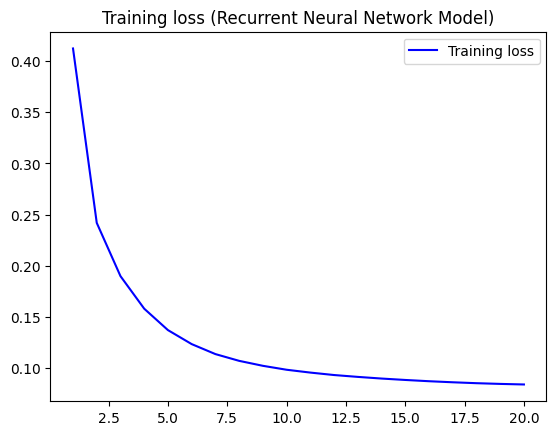

In [48]:
# train the rnn
model = create_RNN(hidden_units=3, dense_units=1,input_shape=(lag, Xtrain.shape[-1]),activation=['tanh', 'tanh'])
history = model.fit(Xtrain, Ytrain, epochs=20, batch_size=1, verbose=2)
plot_model(history, 'Recurrent Neural Network Model', 'rnn_model.png')

yhat_d = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]

train_predict = model.predict(Xtrain)
test_predict = model.predict(Xval)

# Print error
train_rmse, test_rmse = print_error(Ytrain, Yval, train_predict, test_predict)
rmse_table = {
    'model': ['RNN'],
    'training_rmse': [train_rmse],
    'testing_rmse': [test_rmse]
}

#### RNN with regularization


Epoch 1/20
234/234 - 2s - loss: 0.1868 - 2s/epoch - 7ms/step
Epoch 2/20
234/234 - 1s - loss: 0.1288 - 579ms/epoch - 2ms/step
Epoch 3/20
234/234 - 1s - loss: 0.1103 - 567ms/epoch - 2ms/step
Epoch 4/20
234/234 - 1s - loss: 0.1023 - 581ms/epoch - 2ms/step
Epoch 5/20
234/234 - 1s - loss: 0.0972 - 535ms/epoch - 2ms/step
Epoch 6/20
234/234 - 1s - loss: 0.0935 - 568ms/epoch - 2ms/step
Epoch 7/20
234/234 - 1s - loss: 0.0908 - 551ms/epoch - 2ms/step
Epoch 8/20
234/234 - 1s - loss: 0.0886 - 581ms/epoch - 2ms/step
Epoch 9/20
234/234 - 1s - loss: 0.0867 - 571ms/epoch - 2ms/step
Epoch 10/20
234/234 - 1s - loss: 0.0849 - 540ms/epoch - 2ms/step
Epoch 11/20
234/234 - 1s - loss: 0.0834 - 868ms/epoch - 4ms/step
Epoch 12/20
234/234 - 1s - loss: 0.0818 - 863ms/epoch - 4ms/step
Epoch 13/20
234/234 - 1s - loss: 0.0805 - 853ms/epoch - 4ms/step
Epoch 14/20
234/234 - 1s - loss: 0.0792 - 567ms/epoch - 2ms/step
Epoch 15/20
234/234 - 1s - loss: 0.0782 - 543ms/epoch - 2ms/step
Epoch 16/20
234/234 - 1s - loss: 0.07

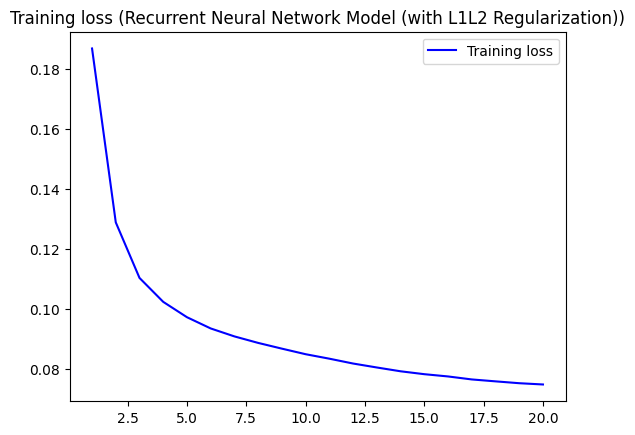

In [50]:
model = create_RNN(hidden_units=3, dense_units=1, input_shape=(lag, Xtrain.shape[-1]),
                   activation=['tanh', 'tanh'], kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
history = model.fit(Xtrain, Ytrain, epochs=20, batch_size=1, verbose=2)
plot_model(history, 'Recurrent Neural Network Model (with L1L2 Regularization)',
           'rnn_reg_model.png')

yhat_d_reg = [x[0] for x in model.predict(Xval)]

train_predict = model.predict(Xtrain)
test_predict = model.predict(Xval)

# Print error
train_rmse, test_rmse = print_error(Ytrain, Yval, train_predict, test_predict)
rmse_table['model'].append(
    'RNN (with L1L2 Regularization)')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)

## GRU

In [ ]:
# define GRU
def create_GRU(hidden_units, dense_units, input_shape, activation, kernel_regularizer=None):
    model = Sequential()
    # Create a simple GRU neural network layer
    model.add(GRU(hidden_units, input_shape=input_shape,
              activation=activation[0]))
    # Add a dense layer (only one, more layers would make it a deep neural net)
    model.add(Dense(units=dense_units,
              activation=activation[1], kernel_regularizer=kernel_regularizer))
    # Compile the model and optimize on MSE
    model.compile(loss='mean_squared_error', optimizer='sgd')
    return model

Epoch 1/20
234/234 - 3s - loss: 0.8717 - 3s/epoch - 11ms/step
Epoch 2/20
234/234 - 1s - loss: 0.8554 - 1s/epoch - 5ms/step
Epoch 3/20
234/234 - 1s - loss: 0.8554 - 946ms/epoch - 4ms/step
Epoch 4/20
234/234 - 1s - loss: 0.8554 - 710ms/epoch - 3ms/step
Epoch 5/20
234/234 - 1s - loss: 0.8554 - 694ms/epoch - 3ms/step
Epoch 6/20
234/234 - 1s - loss: 0.8554 - 699ms/epoch - 3ms/step
Epoch 7/20
234/234 - 1s - loss: 0.8554 - 725ms/epoch - 3ms/step
Epoch 8/20
234/234 - 1s - loss: 0.8554 - 719ms/epoch - 3ms/step
Epoch 9/20
234/234 - 1s - loss: 0.8554 - 750ms/epoch - 3ms/step
Epoch 10/20
234/234 - 1s - loss: 0.8554 - 754ms/epoch - 3ms/step
Epoch 11/20
234/234 - 1s - loss: 0.8554 - 742ms/epoch - 3ms/step
Epoch 12/20
234/234 - 1s - loss: 0.8554 - 742ms/epoch - 3ms/step
Epoch 13/20
234/234 - 1s - loss: 0.8554 - 726ms/epoch - 3ms/step
Epoch 14/20
234/234 - 1s - loss: 0.8554 - 712ms/epoch - 3ms/step
Epoch 15/20
234/234 - 1s - loss: 0.8554 - 753ms/epoch - 3ms/step
Epoch 16/20
234/234 - 1s - loss: 0.8554

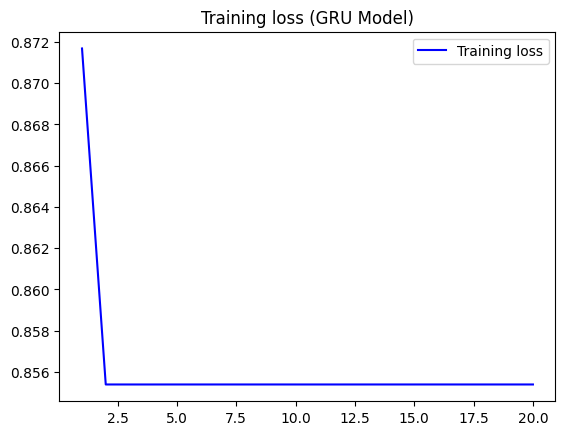

In [51]:
# Training and evaluating a GRU-based model
model = create_GRU(hidden_units=3, dense_units=1, input_shape=(lag, Xtrain.shape[-1]),
                   activation=['tanh', 'relu'])
history = model.fit(Xtrain, Ytrain, epochs=20, batch_size=1, verbose=2)
plot_model(history, 'GRU Model', 'gru_model.png')

yhat_gru = [x[0] for x in model.predict(Xval)]

train_predict = model.predict(Xtrain)
test_predict = model.predict(Xval)

# Print error
train_rmse, test_rmse = print_error(Ytrain, Yval, train_predict, test_predict)
rmse_table['model'].append('GRU')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)

#### GRU with regularization


Epoch 1/20
234/234 - 2s - loss: 0.4014 - 2s/epoch - 10ms/step
Epoch 2/20
234/234 - 1s - loss: 0.3789 - 727ms/epoch - 3ms/step
Epoch 3/20
234/234 - 1s - loss: 0.3773 - 745ms/epoch - 3ms/step
Epoch 4/20
234/234 - 1s - loss: 0.3767 - 702ms/epoch - 3ms/step
Epoch 5/20
234/234 - 1s - loss: 0.3765 - 981ms/epoch - 4ms/step
Epoch 6/20
234/234 - 1s - loss: 0.3764 - 1s/epoch - 5ms/step
Epoch 7/20
234/234 - 1s - loss: 0.3763 - 1s/epoch - 4ms/step
Epoch 8/20
234/234 - 1s - loss: 0.3762 - 734ms/epoch - 3ms/step
Epoch 9/20
234/234 - 1s - loss: 0.3759 - 740ms/epoch - 3ms/step
Epoch 10/20
234/234 - 1s - loss: 0.3760 - 738ms/epoch - 3ms/step
Epoch 11/20
234/234 - 1s - loss: 0.3759 - 722ms/epoch - 3ms/step
Epoch 12/20
234/234 - 1s - loss: 0.3756 - 697ms/epoch - 3ms/step
Epoch 13/20
234/234 - 1s - loss: 0.3755 - 726ms/epoch - 3ms/step
Epoch 14/20
234/234 - 1s - loss: 0.3755 - 721ms/epoch - 3ms/step
Epoch 15/20
234/234 - 1s - loss: 0.3754 - 708ms/epoch - 3ms/step
Epoch 16/20
234/234 - 1s - loss: 0.3752 - 

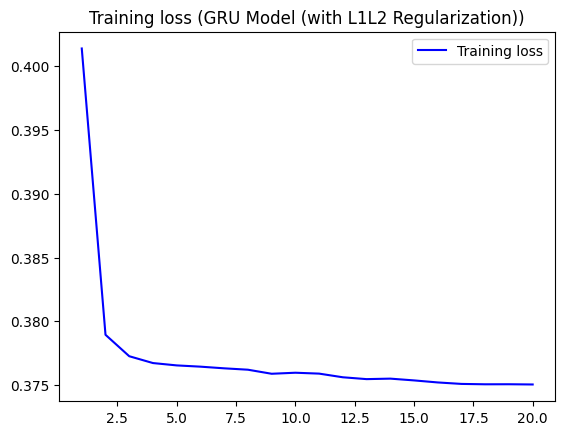

In [52]:
# Training and evaluating a GRU-based model with regularization
model = create_GRU(hidden_units=3, dense_units=1, input_shape=(lag, Xtrain.shape[-1]),
                   activation=['tanh', 'relu'], kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
history = model.fit(Xtrain, Ytrain, epochs=20, batch_size=1, verbose=2)
plot_model(history, 'GRU Model (with L1L2 Regularization)', 'gru_reg_model.png')

yhat_gru_reg = [x[0] for x in model.predict(Xval)]

train_predict = model.predict(Xtrain)
test_predict = model.predict(Xval)

# Print error
train_rmse, test_rmse = print_error(Ytrain, Yval, train_predict, test_predict)
rmse_table['model'].append('GRU (with L1L2 Regularization)')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)

## LSTM

In [53]:
# Create a LSTM Neural Network
def create_LSTM(hidden_units, dense_units, input_shape, activation, kernel_regularizer=None):
    model = Sequential()
    # Create a simple long short term memory neural network
    model.add(LSTM(hidden_units,
              activation=activation[0], input_shape=input_shape))
    # Add a dense layer (only one, more layers would make it a deep neural net)
    model.add(Dense(units=dense_units,
              activation=activation[1], kernel_regularizer=kernel_regularizer))
    # Compile the model and optimize on mean squared error
    model.compile(optimizer="RMSprop", loss='mae')
    return model

Epoch 1/20
234/234 - 3s - loss: 0.5290 - 3s/epoch - 15ms/step
Epoch 2/20
234/234 - 1s - loss: 0.2423 - 812ms/epoch - 3ms/step
Epoch 3/20
234/234 - 1s - loss: 0.1817 - 814ms/epoch - 3ms/step
Epoch 4/20
234/234 - 1s - loss: 0.1521 - 1s/epoch - 4ms/step
Epoch 5/20
234/234 - 1s - loss: 0.1295 - 1s/epoch - 6ms/step
Epoch 6/20
234/234 - 2s - loss: 0.1158 - 2s/epoch - 7ms/step
Epoch 7/20
234/234 - 1s - loss: 0.1093 - 983ms/epoch - 4ms/step
Epoch 8/20
234/234 - 1s - loss: 0.1021 - 961ms/epoch - 4ms/step
Epoch 9/20
234/234 - 1s - loss: 0.0957 - 1s/epoch - 5ms/step
Epoch 10/20
234/234 - 1s - loss: 0.0904 - 1s/epoch - 5ms/step
Epoch 11/20
234/234 - 1s - loss: 0.0860 - 923ms/epoch - 4ms/step
Epoch 12/20
234/234 - 1s - loss: 0.0833 - 785ms/epoch - 3ms/step
Epoch 13/20
234/234 - 1s - loss: 0.0791 - 794ms/epoch - 3ms/step
Epoch 14/20
234/234 - 1s - loss: 0.0773 - 795ms/epoch - 3ms/step
Epoch 15/20
234/234 - 1s - loss: 0.0742 - 802ms/epoch - 3ms/step
Epoch 16/20
234/234 - 1s - loss: 0.0722 - 766ms/epo

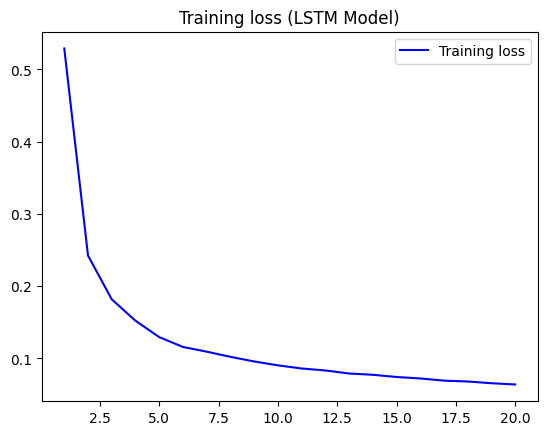

In [54]:
# Training and evaluating a LSTM neural network
model = create_LSTM(hidden_units=3, dense_units=1, input_shape=(lag, Xtrain.shape[-1]),
                    activation=['tanh', 'linear'])
history = model.fit(Xtrain, Ytrain, epochs=20, batch_size=1, verbose=2)
plot_model(history, 'LSTM Model', 'lstm_model.png')

yhat_lstm = [x[0] for x in model.predict(Xval)]

train_predict = model.predict(Xtrain)
test_predict = model.predict(Xval)

# Print error
train_rmse, test_rmse = print_error(Ytrain, Yval, train_predict, test_predict)
rmse_table['model'].append('LSTM')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)

#### LSTM with regularization

Epoch 1/20
234/234 - 3s - loss: 0.9095 - 3s/epoch - 13ms/step
Epoch 2/20
234/234 - 1s - loss: 0.6909 - 741ms/epoch - 3ms/step
Epoch 3/20
234/234 - 1s - loss: 0.4952 - 791ms/epoch - 3ms/step
Epoch 4/20
234/234 - 1s - loss: 0.3379 - 760ms/epoch - 3ms/step
Epoch 5/20
234/234 - 1s - loss: 0.2672 - 814ms/epoch - 3ms/step
Epoch 6/20
234/234 - 1s - loss: 0.2129 - 755ms/epoch - 3ms/step
Epoch 7/20
234/234 - 1s - loss: 0.1734 - 758ms/epoch - 3ms/step
Epoch 8/20
234/234 - 1s - loss: 0.1448 - 771ms/epoch - 3ms/step
Epoch 9/20
234/234 - 1s - loss: 0.1253 - 759ms/epoch - 3ms/step
Epoch 10/20
234/234 - 1s - loss: 0.1092 - 1s/epoch - 5ms/step
Epoch 11/20
234/234 - 1s - loss: 0.0980 - 1s/epoch - 5ms/step
Epoch 12/20
234/234 - 1s - loss: 0.0854 - 963ms/epoch - 4ms/step
Epoch 13/20
234/234 - 1s - loss: 0.0765 - 774ms/epoch - 3ms/step
Epoch 14/20
234/234 - 1s - loss: 0.0708 - 723ms/epoch - 3ms/step
Epoch 15/20
234/234 - 1s - loss: 0.0647 - 773ms/epoch - 3ms/step
Epoch 16/20
234/234 - 1s - loss: 0.0613 - 

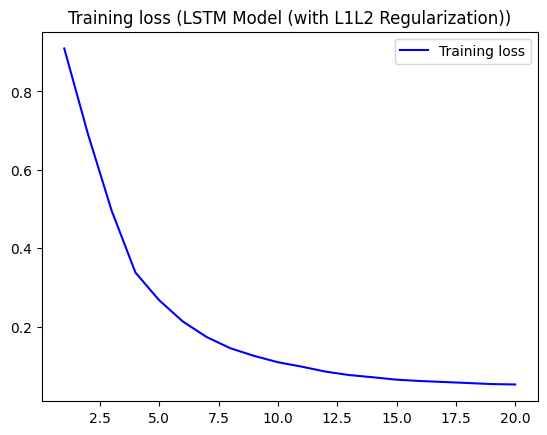

In [55]:
# Create an LSTM neural network with regularization
model = create_LSTM(hidden_units=3, dense_units=1, input_shape=(lag, Xtrain.shape[-1]),
                    activation=['tanh', 'linear'], kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))
history = model.fit(Xtrain, Ytrain, epochs=20, batch_size=1, verbose=2)
plot_model(history, 'LSTM Model (with L1L2 Regularization)',
           'lstm_reg_model.png')

yhat_lstm_reg = [x[0] for x in model.predict(Xval)]

train_predict = model.predict(Xtrain)
test_predict = model.predict(Xval)

# Print error
train_rmse, test_rmse = print_error(Ytrain, Yval, train_predict, test_predict)
rmse_table['model'].append('LSTM (with L1L2 Regularization)')
rmse_table['training_rmse'].append(train_rmse)
rmse_table['testing_rmse'].append(test_rmse)

## Visualize the prediction

Pivoted                   value                                      value_absolute  \
type       gru_forecast lstm_forecast  original rnn_forecast   gru_forecast   
day                                                                           
2020-10-31          0.0      1.694614  1.718043     0.973106  509138.310484   
2020-11-30          0.0      1.700467  1.796367     0.974539  509138.310484   
2020-12-31          0.0      1.713445  1.894714     0.977594  509138.310484   
2021-01-31          0.0      1.735104  1.973849     0.980599  509138.310484   
2021-02-28          0.0      1.760308  2.027560     0.982605  509138.310484   
2021-03-31          0.0      1.783367  2.059353     0.983861  509138.310484   
2021-04-30          0.0      1.802398  2.081533     0.984567  509138.310484   
2021-05-31          0.0      1.816926  2.136076     0.985049  509138.310484   
2021-06-30          0.0      1.825908  2.195648     0.986091  509138.310484   
2021-07-31          0.0      1.834710  2.285

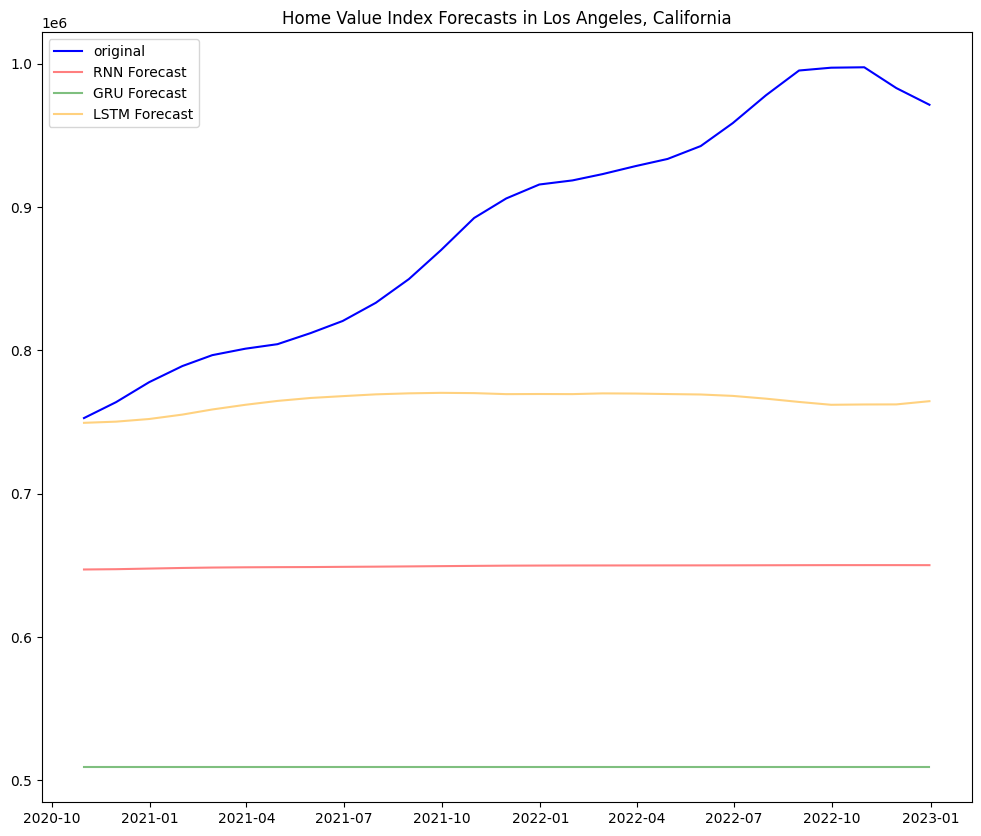

In [56]:
# Creating the frame to store both predictions
days = hvi['date'].values[-len(y):]
frame = pd.concat([
    pd.DataFrame({'day': days, 'value': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'value': yhat_d, 'type': 'rnn_forecast'}),
    pd.DataFrame({'day': days, 'value': yhat_gru, 'type': 'gru_forecast'}),
    pd.DataFrame({'day': days, 'value': yhat_lstm, 'type': 'lstm_forecast'})
])
# Creating the unscaled values column
frame['value_absolute'] = [(x * train_std) + train_mean for x in frame['value']]
# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
print('Pivoted', pivoted)
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]

plt.figure(figsize=(12, 10))
plt.plot(pivoted.index, pivoted.value_absolute_original,
         color='blue', label='original')
plt.plot(pivoted.index, pivoted.value_absolute_rnn_forecast,
         color='red', label='RNN Forecast', alpha=0.5)
plt.plot(pivoted.index, pivoted.value_absolute_gru_forecast,
         color='green', label='GRU Forecast', alpha=0.5)
plt.plot(pivoted.index, pivoted.value_absolute_lstm_forecast,
         color='orange', label='LSTM Forecast', alpha=0.5)
plt.title('Home Value Index Forecasts in Los Angeles, California')
plt.legend()
plt.savefig('nn_forecasts.png')

#### prediction with regularization

Pivoted                   value                                      value_absolute  \
type       gru_forecast lstm_forecast  original rnn_forecast   gru_forecast   
day                                                                           
2020-10-31     1.641840      1.671222  1.718043     0.988422  741942.843245   
2020-11-30     1.650378      1.677650  1.796367     0.988766  743153.489094   
2020-12-31     1.677100      1.694515  1.894714     0.989867  746942.508708   
2021-01-31     1.718044      1.719101  1.973849     0.991014  752748.189595   
2021-02-28     1.761212      1.743646  2.027560     0.991763  758869.099523   
2021-03-31     1.799258      1.763954  2.059353     0.992191  764263.878872   
2021-04-30     1.829259      1.779091  2.081533     0.992417  768517.890481   
2021-05-31     1.852309      1.790074  2.136076     0.992561  771786.323252   
2021-06-30     1.877728      1.800471  2.195648     0.992860  775390.539439   
2021-07-31     1.905033      1.810679  2.285

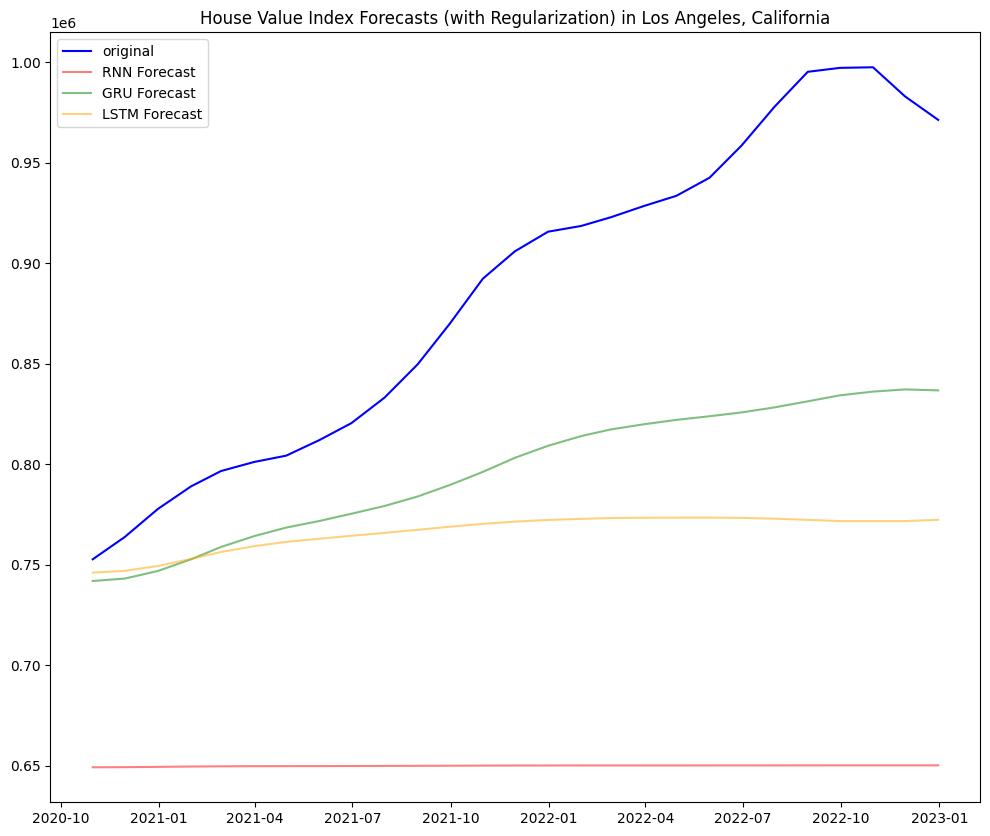

In [57]:
# Creating the frame to store both predictions
days = hvi['date'].values[-len(y):]
frame = pd.concat([
    pd.DataFrame({'day': days, 'value': y, 'type': 'original'}),
    pd.DataFrame({'day': days, 'value': yhat_d_reg, 'type': 'rnn_forecast'}),
    pd.DataFrame({'day': days, 'value': yhat_gru_reg, 'type': 'gru_forecast'}),
    pd.DataFrame({'day': days, 'value': yhat_lstm_reg, 'type': 'lstm_forecast'})
])
# Creating the unscaled values column
frame['value_absolute'] = [(x * train_std) + train_mean for x in frame['value']]
# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
print('Pivoted', pivoted)
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]

plt.figure(figsize=(12, 10))
plt.plot(pivoted.index, pivoted.value_absolute_original,
         color='blue', label='original')
plt.plot(pivoted.index, pivoted.value_absolute_rnn_forecast,
         color='red', label='RNN Forecast', alpha=0.5)
plt.plot(pivoted.index, pivoted.value_absolute_gru_forecast,
         color='green', label='GRU Forecast', alpha=0.5)
plt.plot(pivoted.index, pivoted.value_absolute_lstm_forecast,
         color='orange', label='LSTM Forecast', alpha=0.5)
plt.title('House Value Index Forecasts (with Regularization) in Los Angeles, California')
plt.legend()
plt.savefig('nn_reg_forecasts.png')

## RMSE

In [58]:
rmse_df = pd.DataFrame(rmse_table)
print(rmse_df)
rmse_df.to_csv('rmseLA.csv', index=False)

                             model  training_rmse  testing_rmse
0                              RNN       0.283776      1.754831
1   RNN (with L1L2 Regularization)       0.270782      1.751510
2                              GRU       0.925014      2.712591
3   GRU (with L1L2 Regularization)       0.619353      0.710984
4                             LSTM       0.046311      1.007351
5  LSTM (with L1L2 Regularization)       0.043471      0.980590
